In [1]:
from importlib import reload
import qubic.job_manager_jpm as _jm
from matplotlib import pyplot as plt
import chipcalibration.rabi_experiments as _rabi
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as _cfg
import qubic.rpc_client as _rc
import numpy as np

In [2]:
reload(_jm)
reload(_rabi)

<module 'chipcalibration.rabi_experiments' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_experiments.py'>

In [19]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname, qchip_file='qubitcfg.json')

In [20]:
_jm.JobManager?

In [21]:
runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip)

# GMM Rabi

In [22]:
register = ['Q2', 'Q3']
target_amplitude = qchip.gates['Q2X90'].cfg_dict[0]['amp']
pulse_width_interval = np.linspace(1e-9, 100e-9, 10)

In [23]:
gmm_rabi = _rabi.GMMRabi(register, target_amplitude, pulse_width_interval, 
                       channel_configs=channel_config)

In [24]:
gmm_rabi.circuits[10]

[{'name': 'delay', 't': 0.0004},
 {'name': 'rabi',
  'qubit': ['Q3'],
  'modi': {(0, 'twidth'): 1e-09},
  (0, 'amp'): 0.3724137931034483},
 {'name': 'barrier', 'qubit': ['Q2', 'Q3']},
 {'name': 'read', 'qubit': ['Q2']},
 {'name': 'read', 'qubit': ['Q3']}]

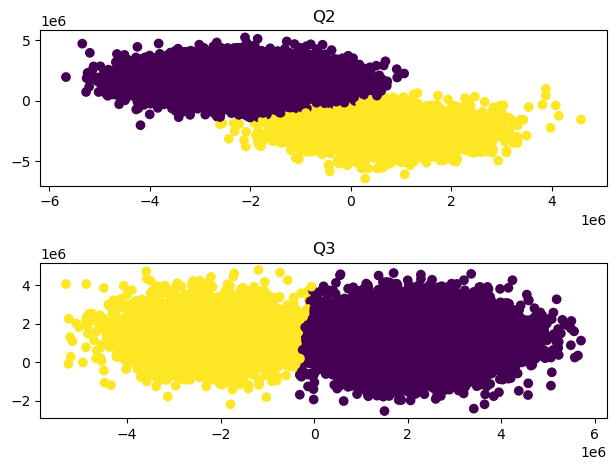

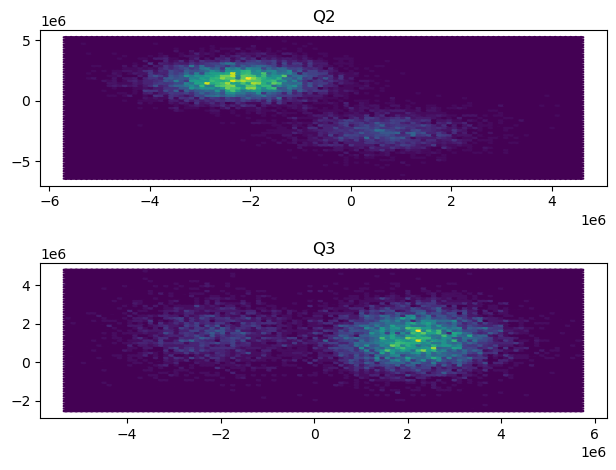

In [25]:
gmm_rabi.run_and_report(jm, 1000, qchip)

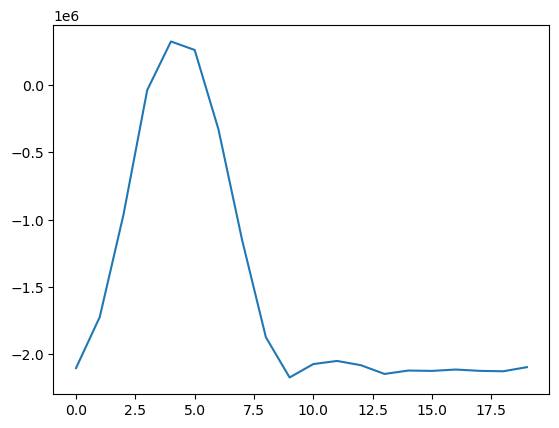

In [26]:
plt.plot(np.average(gmm_rabi.raw_iq_shots['1'].real, axis=1))

In [33]:
gmm_manager = gmm_rabi.gmm_manager

# Time Rabi

I'll target Q2, this time I'll use a jobmanager with a gmm manager 

In [40]:
gmm_manager.gmm_dict

{'Q2': <qubic.state_disc.GMMStateDiscriminator at 0x7fa2082c9450>,
 'Q3': <qubic.state_disc.GMMStateDiscriminator at 0x7fa20823d630>}

In [45]:
reload(_rabi)

<module 'chipcalibration.rabi_experiments' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_experiments.py'>

In [58]:
readout_register = ['Q2', 'Q3']
target_register = ['Q2']
target_amplitude = qchip.gates['Q2X90'].cfg_dict[0]['amp']
pulse_width_interval = np.linspace(0, 200e-9, 20)

In [59]:
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip, gmm_manager=gmm_manager)

In [60]:
trabi = _rabi.TimeRabi(target_register, readout_register, target_amplitude, 
                      pulse_width_interval)

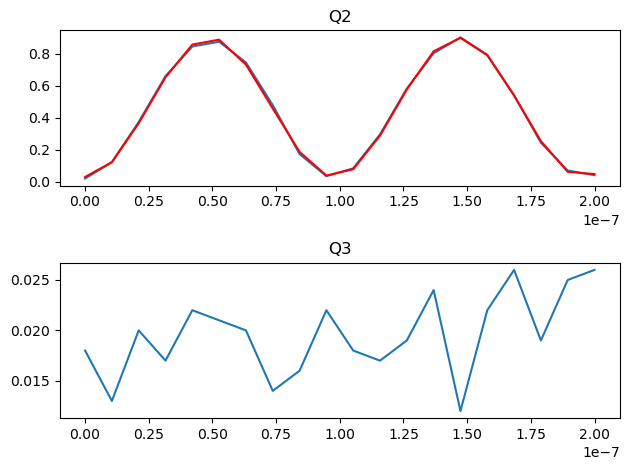

[2.44123019321143e-08, 0.3724137931034483]

In [61]:
trabi.run_and_report(jm, 1000, qchip, fit_type='period', period=90e-9)

In [62]:
qchip.gates['Q2X90'].cfg_dict[0]['twidth']

2.4e-08